In [1]:
# important imports and flags/options
import torch
from torchvision import datasets
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2

#use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check cuda available
print(torch.cuda.is_available())

# options
debug = False
save_results = True
save_model = True
load_model = False
input_to_use = "synthesized0"

True


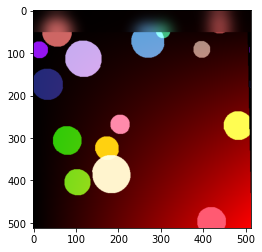

In [2]:
# download sample pictures from github repo

# download sample pictures from github repo
# for i in range(0, 6):
#     !wget https://raw.githubusercontent.com/cmcguinness/focusstack/master/Input/step{i}.jpg

import glob

def load_images():
    images = []
    for i in range(0, 4):
        img_path = glob.glob(f'input/{input_to_use}/step{i}.*')
        img = cv2.imread(img_path[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

# display sample picture
plt.imshow(load_images()[0])

In [3]:
# helper functions

def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt


    homography, mask = cv2.findHomography(image_1_points, image_2_points, cv2.RANSAC, ransacReprojThreshold=2.0)

    return homography

def align_images(images):

    #   SIFT generally produces better results, but it is not FOSS, so chose the feature detector
    #   that suits the needs of your project.  ORB does OK
    use_sift = True

    outimages = []

    if use_sift:
        detector = cv2.xfeatures2d.SIFT_create()
    else:
        detector = cv2.ORB_create(1000)

    #   We assume that image 0 is the "base" image and align everything to it
    print ("Detecting features of base image")
    outimages.append(images[0])
    image1gray = cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY)
    image_1_kp, image_1_desc = detector.detectAndCompute(image1gray, None)

    for i in range(1,len(images)):
        print ("Aligning image {}".format(i))
        image_i_kp, image_i_desc = detector.detectAndCompute(images[i], None)

        if use_sift:
            bf = cv2.BFMatcher()
            # This returns the top two matches for each feature point (list of list)
            pairMatches = bf.knnMatch(image_i_desc,image_1_desc, k=2)
            rawMatches = []
            for m,n in pairMatches:
                if m.distance < 0.7*n.distance:
                    rawMatches.append(m)
        else:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            rawMatches = bf.match(image_i_desc, image_1_desc)

        sortMatches = sorted(rawMatches, key=lambda x: x.distance)
        matches = sortMatches[0:128]



        hom = findHomography(image_i_kp, image_1_kp, matches)
        newimage = cv2.warpPerspective(images[i], hom, (images[i].shape[1], images[i].shape[0]), flags=cv2.INTER_LINEAR)

        outimages.append(newimage)
        # If you find that there's a large amount of ghosting, it may be because one or more of the input
        # images gets misaligned.  Outputting the aligned images may help diagnose that.
        # cv2.imwrite("aligned{}.png".format(i), newimage)



    return outimages

def doLap(image):

    # YOU SHOULD TUNE THESE VALUES TO SUIT YOUR NEEDS
    kernel_size = 5         # Size of the laplacian window
    blur_size = 5           # How big of a kernal to use for the gaussian blur
                            # Generally, keeping these two values the same or very close works well
                            # Also, odd numbers, please...

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_64F, ksize=kernel_size)

def focus_stack(unimages):
    images = align_images(unimages)

    print ("Computing the laplacian of the blurred images")
    laps = []
    for i in range(len(images)):
        print ("Lap {}".format(i))
        laps.append(doLap(cv2.cvtColor(images[i],cv2.COLOR_BGR2GRAY)))

    laps = np.asarray(laps)
    print ("Shape of array of laplacians = {}".format(laps.shape))

    output = np.zeros(shape=images[0].shape, dtype=images[0].dtype)

    abs_laps = np.absolute(laps)
    maxima = abs_laps.max(axis=0)
    bool_mask = abs_laps == maxima
    mask = bool_mask.astype(np.uint8)
    for i in range(0,len(images)):
        output = cv2.bitwise_not(images[i],output, mask=mask[i])
		
    return 255-output

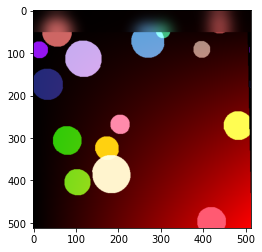

[ WARN:0@13.741] global /io/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


Detecting features of base image
Aligning image 1
Aligning image 2
Aligning image 3
Computing the laplacian of the blurred images
Lap 0
Lap 1
Lap 2
Lap 3


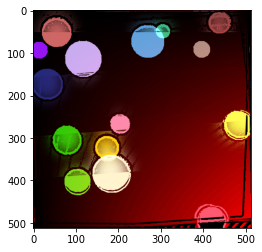

In [4]:
# testing helper functions
images = load_images()
# resize image to 1024x1024
# for i in range(len(images)):
#     images[i] = cv2.resize(images[i], (1024,1024))
# display sample picture
plt.imshow(images[0])
plt.show()

aligned_images = align_images(images)

loader = torch.utils.data.DataLoader(dataset = aligned_images,
                                     batch_size = 1)

print ("Computing the laplacian of the blurred images")
laps = []
for i in range(len(aligned_images)):
    print ("Lap {}".format(i))
    laps.append(doLap(cv2.cvtColor(aligned_images[i],cv2.COLOR_BGR2GRAY)))
laps = np.asarray(laps)


# create mask
abs_laps = np.absolute(laps)
maxima = abs_laps.max(axis=0)
bool_mask = abs_laps == maxima
mask = bool_mask.astype(np.uint8)

output = np.zeros(shape=aligned_images[0].shape, dtype=aligned_images[0].dtype)

for i in range(0,len(aligned_images)):
    output = cv2.bitwise_not(aligned_images[i],output, mask=mask[i])
    
result = 255-output

output_folder = f'output/{input_to_use}'
# save result to output file

# display result
plt.imshow(result)
plt.show()

In [5]:
cv2.imwrite(f'{output_folder}/result.png', result)

False

In [6]:
import os
print(os.getcwd())
# save result to file
output_folder = f'./output/{input_to_use}'
# create folder if it doesn't exist
if not os.path.exists(f'/output/{input_to_use}'):
    os.makedirs(f'/output/{input_to_use}')

# save all aligned images
for i in range(len(aligned_images)):
    cv2.imwrite(f'{output_folder}/aligned{i}.jpg', aligned_images[i])
cv2.imwrite(f'{output_folder}/result.jpg', result)

/home/nasseraa/inversion-analysis/focal_stacking


PermissionError: [Errno 13] Permission denied: '/output'